# What is the difference between Data Analysts and Data Scientists?

Please find all relevant information about this notebook in the README.md in this repository

# Preparations

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import holoviews as hv
from matplotlib_venn import venn2
from holoviews import opts, dim
from scipy.stats import ttest_ind_from_stats

In [2]:
os.chdir(r"C:\Users\j\Documents\udacity-ds-nanodegree\assignment1\data")

In [3]:
pd.set_option("display.max_columns", None)

## Read in data

In [4]:
dfk = pd.read_csv(
    r"C:\Users\j\Documents\udacity-ds-nanodegree\assignment1\data\kaggle_ds_jobs\DataScientist.csv")

In [5]:
dfs = pd.read_csv(r"stackoverflow_survey\survey_results_public.csv")

## Define functions

In [6]:
def subset_creator(df, column_list):
    '''
    INPUT:
    df: dataframe
    column_list: list of strings, contains columns from which unique strings 
        need to be extracted.

    OUTPUT:
    super_list2: list of strings, contains unique values from columns 
        in column_list.

    What this function does:
    Creates list of values from column(s).  Takes in columns which contain 
    string values, where each row can contained multiple values separated 
    by a delimiter (e.g. 'dog;cat;rabbit').  Extracts all unique string values 
    column_list and return them in super_list2. 
    Each value is only contained once in super_list2.
    '''
    df = df.fillna('No information')
    super_list = []
    
    # Extract unique values from each column
    for i in column_list:
        nested_list = list(df[i].str.split(';'))
        flat_list = [item for sublist in nested_list for item in sublist]
        all_set = set(flat_list)
        all_list = list(all_set)
        super_list.append(all_list)
        
    # Flatten list
    super_list = [item for sublist in super_list for item in sublist]
    
    # Remove duplicate values
    super_list_all_set = set(super_list)
    super_list_all_list = list(super_list_all_set)
    
    # Remove 'No information'
    super_list2 = [i for i in super_list_all_list if i != 'No information']
    
    return super_list2

In [7]:
def grouping_formatting(df, column):
    '''
    INPUT:
    df: df to be reformatted
    column: string that sets column name

    OUTPUT:
    df: reformatted dataframe

    What this function does:
    Reformats the dataframe after running groupby. 
    It is used inside the grouping function.
    '''
    df = df.reset_index()
    df = df.drop(columns=[0], axis=1)
    df = df.rename(columns={"index": "Categories", 1: column})
    return df

In [8]:
def grouping(df, all_items, column, bs):
    '''
    INPUT:
    df: dataframe with all data
    all_devtypes: list of strings that contains all different Developer roles
    column: name of binary coded column
    bs: True/False value indicating whether to include base sizes

    OUTPUT:
    df_cooc: co-occurence dataframe that is transposed and contains column 
        % based on total and - if wanted - base sizes

    What this function does:
    Generates the co-occurence dataframe for all 2-way split analyses
    '''
    # Save base size n for variable (e.g. back-end developer) of interest
    n = df[column].sum()

    # Run groupby, transpose and divide counts by n
    df_cooc = df.groupby([column])[all_items].sum().transpose()/n

    # Tidy up the new df using grouping_formatting function
    df_cooc = grouping_formatting(df_cooc, column)

    # Add in base size if requested
    if bs:
        df_bs = df.groupby([column])[all_items].sum().transpose()
        df_bs = grouping_formatting(df_bs, column)

        # Change column names to indicate it is base size
        bs_columns = list(df_bs.columns)
        bs_columns.remove("Categories")
        for i in bs_columns:
            df_bs = df_bs.rename(columns={i: i+"_bs"})

        # Merge
        df_cooc = pd.merge(df_cooc,
                           df_bs,
                           left_on='Categories',
                           right_on='Categories')

    return df_cooc

In [11]:
def dummies(df, column_list):
    '''
    INPUT:
    df: dataframe with all data
    column_list: list of strings that contains all columns
        for which dummies need to be created

    OUTPUT:
    df: df with new dummy columns
    issue_list: list of strings that contains all duplicate columns

    What this function does:
    Creates dummy columns for categorical variables
    and deals with duplicates if needed
    '''
    for i in column_list:
        df_interim = df[i].str.get_dummies(sep=';')
        df = pd.merge(df,
                      df_interim,
                      left_index=True,
                      right_index=True)

    # --------------------------------------------------------------#
    # ---------Remove duplicated columns if they exist--------------#
    # --------------------------------------------------------------#

    # NOTE: this works only on duplicates, not on triplicates and higher
    header_list = df.columns

    # Find all duplicated columns that end in _x and _y
    issue_list = [i for i in header_list if re.match('.+_\D$', i)]

    # Remove duplicated columns
    if issue_list:
        issue_list = sorted(issue_list)

        # Create list of even numbers based on number of issue pairs
        iter_list = [x for x in range(len(issue_list)) if x % 2 == 0]

        # Add up columns, drop old columns
        for i in iter_list:
            a = issue_list[i]
            b = issue_list[i+1]
            b_new = b[:-2]  # Create new column name
            df[b_new] = df[a] + df[b]
            df.loc[df[b_new] > 1, b_new] = 1

    return df, issue_list

In [12]:
def t_testing(df, dvar, sample1, sample2, base1, base2, removal_list):
    '''
    INPUT:
    df: dataframe with all data
    dvar: list of all dependent variables
    sample1/sample2: string to define name of sample and column 
        that contains mean score (e.g. DA_share)
    base1/base2: integers; base sizes for both samples
    removal_list: list of strings that contains dev_roles
        that constitute samples 1 and 2

    OUTPUT:
    result_dict: dictionary with results of t-tests

    What this function does:
    Runs two sample t-tests for independent samples and returns test statistic and p-value
    '''
    result_dict = {}
    
    # Define list of dependent variables
    reduced_dvar = [i for i in dvar if i not in removal_list]
    
    # Run t-tests
    for i in reduced_dvar:
        mean1 = df.loc[i, sample1]
        mean2 = df.loc[i, sample2]
        std1 = np.sqrt(mean1*(1-mean1))
        std2 = np.sqrt(mean2*(1-mean2))
        t_result = ttest_ind_from_stats(mean1=mean1, 
                                        std1=std1,
                                        nobs1=base1,
                                        mean2=mean2,
                                        std2=std2,
                                        nobs2=base2)
        result_dict[i] = {'test_statistic': t_result[0], 
                          'p-value': t_result[1]}
        df_result = pd.DataFrame(result_dict).transpose()

        # Calculate adjusted alpha
        bonferroni_adj = 0.05/len(dvar)

        # Create list of all dvars where difference is significant
        sig_dvar = df_result.loc[df_result['p-value'] <= bonferroni_adj]
        sig_dvar = sig_dvar.index.to_list()

        # Style output table
        df_result = df_result.style.apply(
            lambda x: ["background: green" if v <= bonferroni_adj else "" for v in x], 
            subset=['p-value'], 
            axis=1)

    return df_result, bonferroni_adj, sig_dvar

In [13]:
def grouping_1col(dataset, df, key_column, dvar, n_dict):
    '''
    INPUT
    dataset: String, states which dataset is used: Kaggle or Stackoverflow 
    df: dataframe to build grouped data frames from (dfs, dfs_tools, dfk_f)
    key_column: column name as string of column by which groupby happens
    dvar: list of columns which need to show in grouped table
    n_dict: dictionary for base sizes

    OUTPUT:
    df: co-occurence dataframe with base sizes and endorsement

    What this function does:
    Returns a co-occurence dataframe with base sizes
    and shares for cases where groupby needs to happen only by one column
    '''
    # Create a co-occurence table
    df_cooc = df.groupby(key_column)[dvar].sum().transpose()

    # Add % columns into the co-occurence table
    for key in n_dict:
        col_name = str(key+'_share')
        n = n_dict[key]
        df_cooc[col_name] = df_cooc[key]/n

    # Create Difference column
    if dataset == 'Stackoverflow':
        df_cooc['Difference'] = (df_cooc['DS_only_share']
                                 - df_cooc['DA_only_share'])
    elif dataset == 'Kaggle':
        df_cooc['Difference'] = (df_cooc['DS_share']
                                 - df_cooc['DA_share'])
    else:
        print("The dataset submitted is unknown")

    return df_cooc

In [14]:
def sig_stars(df, sig_dvar):
    '''
    INPUT
    df: dataframe, co-occurence type
    sig_dvar: list of variables where difference was significant

    OUTPUT:
    df: dataframe, same as input, but with sig stars in index column

    What this function does:
    Adds significance stars to the grouped table, 
    so that in chart it's visible which differences are significant
    '''
    df = df.reset_index()
    df.loc[df['index'].isin(sig_dvar), 'index'] = df['index'].apply(
        lambda x: "{}{}".format(x, '**'))
    df = df.set_index('index')
    return df

In [15]:
def plotting(df, hue1, hue2, ylabel, xlabel, title, legend1, legend2):
    '''
    INPUT
    df: dataframe that contains data to be plotted
        (needs to be co-occurence style table with shares)
    hue1, hue2: strings that refer to groups for separate columns
    ylabel, xlabel, title: strings for labelling and title
    legend1, legen2: strings to rename legend entries

    OUTPUT:
    none

    What this function does:
    Creates horizontal barchart
    '''
    fig, ax1 = plt.subplots()

    # Plotsize
    plt.rcParams["figure.figsize"] = [10, 15]

    # Styling
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
    plt.rcParams['axes.edgecolor'] = '#333F4B'
    plt.rcParams['axes.linewidth'] = 0.8
    plt.rcParams['xtick.color'] = '#333F4B'
    plt.rcParams['ytick.color'] = '#333F4B'

    # Data
    df[[hue1,
        hue2,
        'Difference']].sort_values(by=['Difference']).plot.barh(ax=ax1,
                                                                color={
                                                                    hue1: '#2230AF',
                                                                    hue2: '#6699FF',
                                                                    'Difference': '#DA1F26'})

    # Grid
    ax1.grid(axis='x')
    ax1.set_axisbelow(True)

    # Labels
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)

    # legend
    plt.legend([legend1, legend2, 'Difference'])

    # Colour of axis labels and header
    ax1.xaxis.label.set_color('#333F4B')
    ax1.yaxis.label.set_color('#333F4B')
    ax1.title.set_color('#333F4B')
    ax1.title.set_size(14)

    plt.show()

In [16]:
def merging_2col(df1, df2):
    '''
    INPUT
    df1, df2: dataframes that need to be merged

    OUTPUT:
    df: merged dataframe

    What this function does:
    Merges two dataframes on 'Category' and sets 'Category' as index
    '''
    df = pd.merge(df1,
                  df2,
                  left_on='Categories',
                  right_on='Categories')
    df = df.set_index('Categories')
    return df

In [17]:
def diffcol_2col(df):
    '''
    INPUT
    df: dataframe

    OUTPUT:
    df: dataframe

    What this function does:
    Adds column that shows difference between DA and DS columns
    '''
    df['Difference'] = (df['Data scientist or machine learning specialist']
                        - df['Data or business analyst'])
    return df

In [18]:
def endorsement(min_end, df, c1, c2):
    '''
    INPUT
    min_end: minimum endorsement value, i.e. cut-off for df
    df: dataframe
    c1, c2: columns for which endorsement level needs to be checked

    OUTPUT:
    df: filtered dataframe

    What this function does:
    Filters dataframe based on values in columns c1 and c2
    '''
    df = df.loc[(df[c1] > min_end) | (df[c2] > min_end)]
    return df

# Part 1 - The Stackoverflow Data

## Inspect data

In [19]:
dfs.head(5)

Respondent                                         MainBranch Hobbyist  \
0           1                     I am a developer by profession      Yes   
1           2                     I am a developer by profession       No   
2           3                        I code primarily as a hobby      Yes   
3           4                     I am a developer by profession      Yes   
4           5  I used to be a developer by profession, but no...      Yes   

    Age Age1stCode CompFreq  CompTotal  ConvertedComp             Country  \
0   NaN         13  Monthly        NaN            NaN             Germany   
1   NaN         19      NaN        NaN            NaN      United Kingdom   
2   NaN         15      NaN        NaN            NaN  Russian Federation   
3  25.0         18      NaN        NaN            NaN             Albania   
4  31.0         16      NaN        NaN            NaN       United States   

     CurrencyDesc CurrencySymbol DatabaseDesireNextYear  \
0   European Euro            EUR   Microsoft SQL Server   
1  Pound sterling            GBP                    NaN   
2             NaN            NaN                    NaN   
3    Albanian lek            ALL                    NaN   
4             NaN            NaN       MySQL;PostgreSQL   

                          DatabaseWorkedWith  \
0  Elasticsearch;Microsoft SQL Server;Oracle   
1                                        NaN   
2                                        NaN   
3                                        NaN   
4              MySQL;PostgreSQL;Redis;SQLite   

                                             DevType  \
0  Developer, desktop or enterprise applications;...   
1            Developer, full-stack;Developer, mobile   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                           EdLevel  \
0  Master’s degree (M.A., M.S., M.Eng., MBA, etc.)   
1     Bachelor’s degree (B.A., B.S., B.Eng., etc.)   
2                                              NaN   
3  Master’s degree (M.A., M.S., M.Eng., MBA, etc.)   
4     Bachelor’s degree (B.A., B.S., B.Eng., etc.)   

                                          Employment  \
0  Independent contractor, freelancer, or self-em...   
1                                 Employed full-time   
2                                                NaN   
3                                                NaN   
4                                 Employed full-time   

                      Ethnicity Gender  \
0  White or of European descent    Man   
1                           NaN    NaN   
2                           NaN    NaN   
3  White or of European descent    Man   
4  White or of European descent    Man   

                                          JobFactors                 JobSat  \
0  Languages, frameworks, and other technologies ...     Slightly satisfied   
1                                                NaN      Very dissatisfied   
2                                                NaN                    NaN   
3  Flex time or a flexible schedule;Office enviro...  Slightly dissatisfied   
4                                                NaN                    NaN   

                                             JobSeek  \
0       I am not interested in new job opportunities   
1       I am not interested in new job opportunities   
2                                                NaN   
3  I’m not actively looking, but I am open to new...   
4                                                NaN   

     LanguageDesireNextYear        LanguageWorkedWith  \
0    C#;HTML/CSS;JavaScript    C#;HTML/CSS;JavaScript   
1              Python;Swift          JavaScript;Swift   
2  Objective-C;Python;Swift  Objective-C;Python;Swift   
3                       NaN                       NaN   
4           Java;Ruby;Scala         HTML/CSS;Ruby;SQL   

             MiscTechDesir

In [20]:
print("The original base size is", dfs.shape[0])
print("The number of columns is", dfs.shape[1])

The original base size is 64461
The number of columns is 61


In [21]:
# Inspect data types and missing values
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Respondent                    64461 non-null  int64  
 1   MainBranch                    64162 non-null  object 
 2   Hobbyist                      64416 non-null  object 
 3   Age                           45446 non-null  float64
 4   Age1stCode                    57900 non-null  object 
 5   CompFreq                      40069 non-null  object 
 6   CompTotal                     34826 non-null  float64
 7   ConvertedComp                 34756 non-null  float64
 8   Country                       64072 non-null  object 
 9   CurrencyDesc                  45472 non-null  object 
 10  CurrencySymbol                45472 non-null  object 
 11  DatabaseDesireNextYear        44070 non-null  object 
 12  DatabaseWorkedWith            49537 non-null  object 
 13  D

**How to handle missings**
* Respondents with no information on DevType need to be excluded >> See filtering
* Missings in columns referring to tools used and tools desired next year mean that a respondent did not use/does not want to use any tool/tech from the specific category, which is a legitimate answer and not actually a missing data value.
* No missing values need to be imputed

## Filter  (includes creating dummy variables for DevTypes)

**Sensible filters**

**MainBranch**: Developers by profession; code sometimes as part of their work

**Employment**: Employed full-time; employed part-time; independent contractor, freelancer or self-employed

**DevType**: Not NA >> This is used for grouping sample into Data Analysts and Data Scientists, hence cannot work with null values

**DevType**: Data or business analyst; Data scientist or machine learning specialist >> This is my desired sample for Q1.1.1, Q1.2, Q1.3

In [22]:
# Filter on MainBranch
dfs = dfs.loc[(dfs['MainBranch'] == "I am a developer by profession") 
              | (dfs['MainBranch'] == "I am not primarily a developer, but I write code sometimes as part of my work")]

In [23]:
# Filter on Employment status
dfs = dfs.loc[(dfs['Employment'] == "Employed full-time") 
              | (dfs['Employment'] == "Employed part-time")
              | (dfs['Employment'] == "Independent contractor, freelancer, or self-employed")]

In [24]:
# Filert on DevType != NaN
dfs = dfs.dropna(subset=['DevType'])

In [25]:
# Create columns for DevTypes
dfs_d1 = dfs['DevType'].str.get_dummies(sep=';')

In [26]:
# Merge dummy dataframe onto original dataframe
dfs = pd.merge(dfs, 
               dfs_d1, 
               left_index=True, 
               right_index=True)

In [27]:
# Create df that is not filtered by DevType. Needed for Q1.1.2.
df_chord = dfs

In [28]:
# Filter on respondents that work as Data Scientist or Data Analyst
dfs = dfs.loc[(dfs['Data or business analyst'] == 1) 
              | (dfs['Data scientist or machine learning specialist'] == 1)]

In [29]:
# Check new base size
print("The new base size after filtering is", dfs.shape[0])

The new base size after filtering is 5952


## Question 1.1.1: How distinctive are the Data Analyst and the Data Scientist roles from each other?

### How many % of people are Data Analysts, how many Data Scientists and how many are both?

% of people who work as Data Analysts, Data Scientists and both

In [30]:
pct_da = dfs['Data or business analyst'].mean()*100
pct_ds = dfs['Data scientist or machine learning specialist'].mean()*100

dfs['DA and DS'] = 0
dfs.loc[(dfs['Data or business analyst'] == 1)
        & (dfs['Data scientist or machine learning specialist'] == 1),
        'DA and DS'] = 1
pct_dads = dfs['DA and DS'].mean()*100

C:\Users\j\Python\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\j\Python\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [31]:
print ("{:.2f}% of respondents in the sample are Data Analysts".format(pct_da))
print ("{:.2f}% of respondents in the sample are Data Scientists".format(pct_ds))
print ("{:.2f}% of respondents in the sample are both".format(pct_dads))

59.43% of respondents in the sample are Data Analysts
59.29% of respondents in the sample are Data Scientists
18.72% of respondents in the sample are both


In [32]:
# Create a variable to identify DAs, DSs and those who are both DA and DS >> Needed for further analysis
dfs['DevType_RoleDescription'] = np.nan
dfs.loc[dfs['DA and DS'] == 1, 'DevType_RoleDescription'] = 'DA_and_DS'
dfs.loc[(dfs['DA and DS'] == 0)
        & (dfs['Data scientist or machine learning specialist'] == 1),
        'DevType_RoleDescription'] = 'DS_only'
dfs.loc[(dfs['DA and DS'] == 0)
        & (dfs['Data or business analyst'] == 1),
        'DevType_RoleDescription'] = 'DA_only'

C:\Users\j\Python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\j\Python\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\j\Python\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

### Create base sizes for further analysis

Get base size for each of the three groups (DA only, DS only, DA and DS)

In [33]:
n_da_only = dfs.loc[dfs['DevType_RoleDescription']
                    == 'DA_only']['Respondent'].count()
n_ds_only = dfs.loc[dfs['DevType_RoleDescription']
                    == 'DS_only']['Respondent'].count()
n_da_and_ds = dfs.loc[dfs['DevType_RoleDescription']
                      == 'DA_and_DS']['Respondent'].count()

In [34]:
print("Base size DA only: ", n_da_only)
print("Base size DS only: ", n_ds_only)
print("Base size DA and DS: ", n_da_and_ds)

Base size DA only:  2423
Base size DS only:  2415
Base size DA and DS:  1114


Venn diagram to show overlap

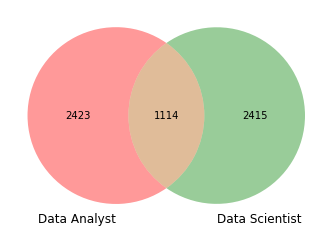

In [35]:
venn2(subsets=(n_da_only, n_ds_only, n_da_and_ds),
      set_labels=('Data Analyst', 'Data Scientist'))
plt.show()

Get base size for two groups (DS, DA >> They have a certain overlap)

In [36]:
n_da = dfs['Data or business analyst'].sum()
n_ds = dfs['Data scientist or machine learning specialist'].sum()

In [37]:
print("Base size DA: ", n_da)
print("Base size DS: ", n_ds)

Base size DA:  3537
Base size DS:  3529


### How distinctive are the DA and DS role from other roles in the field?

In [38]:
# Retrieve all DevTypes from the Stackoverflow data
all_devtypes = subset_creator(dfs, ['DevType'])

#### How many respondents claim to ONLY be a Data Analyst or a Data Scientist?

In [39]:
# Create column that shows number of roles chosen
dfs['NumberOfRoles'] = dfs[all_devtypes].sum(axis=1)

C:\Users\j\Python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
pd.crosstab(dfs['NumberOfRoles'], dfs['DevType_RoleDescription'])

DevType_RoleDescription  DA_and_DS  DA_only  DS_only
NumberOfRoles                                       
1                                0      225      325
2                              164      313      476
3                              174      344      495
4                              151      292      395
5                              124      315      248
6                               98      246      147
7                               85      203      118
8                               56      136       59
9                               52      120       47
10                              40       71       33
11                              25       58       28
12                              33       34       23
13                              21       25       10
14                              16       20        5
15                              16        5        2
16                               9        8        1
17                               9        1        2
18                               5        4        0
19                               5        3        0
20                               4        0        0
21                               1        0        0
22                               2        0        1
23                              24        0        0

#### How many roles do respondents say they fill on average?

When sample split 3 ways

In [41]:
dfs.groupby('DevType_RoleDescription')['NumberOfRoles'].mean()

DevType_RoleDescription
DA_and_DS    6.427289
DA_only      5.118035
DS_only      3.892754
Name: NumberOfRoles, dtype: float64

When sample split 2 ways

In [42]:
n_roles_da = dfs.loc[dfs['Data or business analyst'] == 1,
                     'NumberOfRoles'].mean()
n_roles_ds = dfs.loc[dfs['Data scientist or machine learning specialist'] == 1,
                     'NumberOfRoles'].mean()

print("Data Analysts have on average {:.2f} roles".format(n_roles_da))
print("Data Scientists have on average {:.2f} roles".format(n_roles_ds))

Data Analysts have on average 5.53 roles
Data Scientists have on average 4.69 roles


#### What else do they claim to be?

##### Analysis for 3-way split (DA only, DS only, DA and DS)

Create grouped co-occurence table

In [43]:
# Create dictionary for base sizes
n_dicts = {'DA_only': n_da_only,
           'DS_only': n_ds_only, 
           'DA_and_DS': n_da_and_ds}

In [44]:
dfs_cooc1 = grouping_1col('Stackoverflow', 
                          dfs,
                          'DevType_RoleDescription', 
                          all_devtypes, 
                          n_dicts)

Sig test

In [45]:
removal_list = ['Data or business analyst',
                'Data scientist or machine learning specialist']
dfs_result_devtypes, dfs_result_devtypes_ba, sig_dvar_s_devtypes = t_testing(dfs_cooc1,
                                                                             list(dfs_cooc1.index),
                                                                             'DA_only_share',
                                                                             'DS_only_share',
                                                                             n_da_only,
                                                                             n_ds_only,
                                                                             removal_list)

Add sig stars to table pre-charting

In [46]:
dfs_cooc1 = sig_stars(dfs_cooc1, sig_dvar_s_devtypes)

Remove rows from removal_list for charting

In [47]:
for i in removal_list:
    dfs_cooc1 = dfs_cooc1.drop(index=i)

Chart

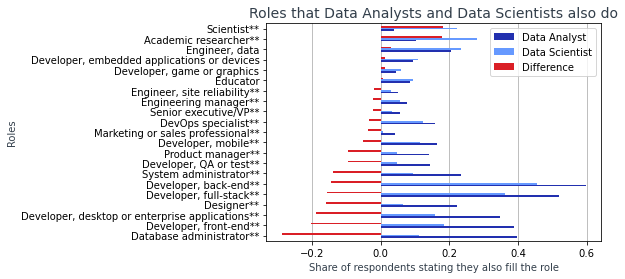

In [48]:
plotting(dfs_cooc1,
         'DA_only_share',
         'DS_only_share',
         'Roles',
         'Share of respondents stating they also fill the role',
         'Roles that Data Analysts and Data Scientists also do',
         'Data Analyst',
         'Data Scientist')

##### Analysis for 2-way split with partial overlap (DA, DS)

Data preparation

In [49]:
# Create a co-occurence table
dfs_cooc2_da = grouping(dfs,
                        all_devtypes,
                        'Data or business analyst',
                        True)
dfs_cooc2_ds = grouping(dfs,
                        all_devtypes,
                        'Data scientist or machine learning specialist',
                        True)
dfs_cooc2 = merging_2col(dfs_cooc2_da, dfs_cooc2_ds)

# Adding a Difference column
dfs_cooc2 = diffcol_2col(dfs_cooc2)

Chart

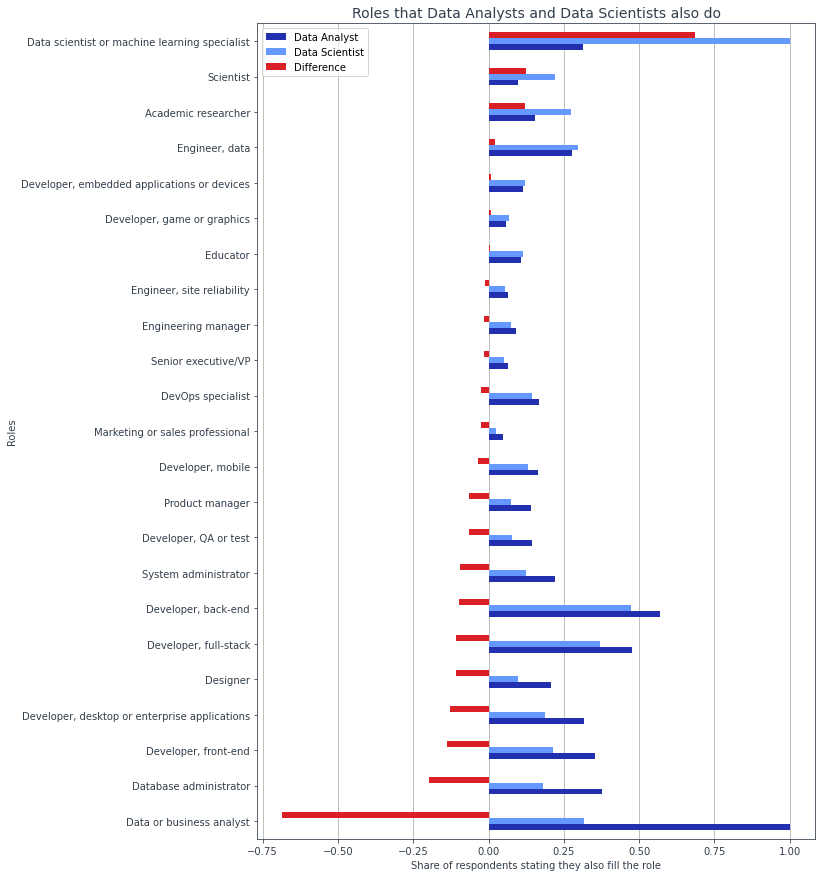

In [50]:
plotting(dfs_cooc2,
         'Data or business analyst',
         'Data scientist or machine learning specialist',
         'Roles',
         'Share of respondents stating they also fill the role',
         'Roles that Data Analysts and Data Scientists also do',
         'Data Analyst',
         'Data Scientist')

## Question 1.1.2: How distinctive are Data Analyst and Data Scientist roles from any other role in general?  >> Chord chart


Notes:
This chart doesn't use the dataset filtered only on Data Analysts and Data Scientist. All DevTypes are included. The size of the node shows the base size for the respective DevType. The arches (and consequently the width of each DevType segment) show which other DevTypes the respondents claim to be as well. That means that a small segment with a large node shows that a smaller share of this DevType claims to also be another DevType, whereas a large segment with a small node shows that people of this DevType claim to also be many other DevTypes.

Problems with modules: 
* Chord: States the rate limit is exceeded
* Bokeh and Holoviews: There is currently no workaround for truncated labels it seems: https://discourse.holoviz.org/t/chord-diagram-labels-got-trancated/663/2

##### Understand how many respondents state they have multiple roles

In [51]:
df_chord['NumberOfRoles'] = df_chord[all_devtypes].sum(axis=1)

Show how many respondents have only 1 role, how many have 2 etc...

In [52]:
df_chord['NumberOfRoles'].value_counts()

1     12456
2      8974
3      8118
4      5673
5      3670
6      2358
7      1444
8       877
9       549
10      339
11      212
12      138
13       84
14       51
15       29
23       24
16       23
17       13
18        9
19        8
20        5
22        3
21        1
Name: NumberOfRoles, dtype: int64

### Create a co-occurence matrix

##### Prepare data for chord chart using hologram and bokeh

Create a co-occurence matrix

In [53]:
df_ng = df_chord[all_devtypes]

In [54]:
df_ngt = df_ng.T.dot(df_ng)

In [55]:
np.fill_diagonal(df_ngt.values, 0)

In [56]:
df_ngt.values[np.tril(np.ones(df_ngt.shape)).astype(bool)] = 0

Create an edge-list

In [57]:
df_ngt_stacked = df_ngt.stack()

In [58]:
df_ngt_stacked = df_ngt_stacked[df_ngt_stacked >= 1].rename_axis(
    ('node1', 'node2')).reset_index(name='weight')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
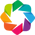

In [59]:
hv.extension('bokeh')
hv.output(size=200)

Retrieve node size data

In [60]:
# Need count of all DevTypes (use df_chord)
df_devtype_count = pd.DataFrame(df_chord[all_devtypes].sum())

In [61]:
df_devtype_count = df_devtype_count.reset_index()

In [62]:
df_devtype_count = df_devtype_count.rename(
    columns={'index': 'DevType', 0: 'size'})

In [63]:
# Reduce base for nodes to have sensible sizes
df_devtype_count['size'] = df_devtype_count['size'] / 500

In [64]:
df_devtype_count

DevType    size
0                           Developer, full-stack  50.660
1                             Senior executive/VP   2.274
2                      Engineer, site reliability   3.588
3     Developer, embedded applications or devices   8.722
4                                 Product manager   4.328
5                                  Engineer, data   6.832
6                          Database administrator  10.446
7                             Academic researcher   6.114
8                           Developer, QA or test   7.264
9                     Developer, game or graphics   4.696
10                            Engineering manager   4.860
11                            Developer, back-end  50.654
12                              DevOps specialist  11.390
13                           Developer, front-end  33.512
14                                       Educator   5.048
15                Marketing or sales professional   0.984
16                                       Designer   9.064
17                       Data or business analyst   7.074
18                              Developer, mobile  17.154
19                           System administrator   9.296
20  Data scientist or machine learning specialist   7.058
21  Developer, desktop or enterprise applications  21.864
22                                      Scientist   3.666

Create nodes data

In [65]:
df_devtype_count = df_devtype_count.reset_index()

In [66]:
df_devtype_count = df_devtype_count.rename(columns={'DevType': 'name'})

In [67]:
# Turn Dataframe into a Dataset
nodes = hv.Dataset(df_devtype_count, 'index')

Format edge-list dataframe

In [68]:
# Get a dictionary of index and name
node_dict = nodes.data.set_index('name').to_dict()['index']

# Map dict values to df
# Strings need to be replaced with integers for chart to compile
df_chord2 = df_ngt_stacked.replace({'node1': node_dict, 
                                    'node2': node_dict})

##### Create chart

In [69]:
# Note : weight sets threshold from when a connection is shown.
chord = hv.Chord((df_chord2, nodes)).select(weight=(100, None))
chord.opts(
    opts.Chord(cmap='Category20',
               edge_cmap='Category20',
               labels='name',
               node_color=dim('index').str(),
               node_size='size'))

:Chord   [node1,node2]   (weight)

## Question 1.2: Do tools used by Data Analysts differ from tools used by Data Scientists?

In [70]:
# List all columns that refer to tech and tools variables
column_list = ['MiscTechWorkedWith',
               'LanguageWorkedWith',
               'NEWCollabToolsWorkedWith',
               'DatabaseWorkedWith',
               'PlatformWorkedWith',
               'WebframeWorkedWith']

In [71]:
# Create columns in df for all tools
dfs_tools, issue_list = dummies(dfs, column_list)

In [72]:
# Create list with all tools
all_tools = subset_creator(dfs_tools, column_list)

##### Analysis for 3-way split (DA only, DS only, DA and DS)

Create grouped co-occurence table

In [73]:
dfs_cooc3 = grouping_1col('Stackoverflow',
                          dfs_tools,
                          'DevType_RoleDescription',
                          all_tools,
                          n_dicts)

Remove variables with low endorsement

In [74]:
dfs_cooc3 = endorsement(0.3,
                        dfs_cooc3,
                        'DA_only_share',
                        'DS_only_share')

Sig-test

In [75]:
dfs_result_tools, dfs_result_tools_ba, sig_dvar_s_tools = t_testing(dfs_cooc3,
                                                                    list(dfs_cooc3.index),
                                                                    'DA_only_share',
                                                                    'DS_only_share',
                                                                    n_da_only,
                                                                    n_ds_only,
                                                                    [])

Add sig stars to table pre-charting

In [76]:
dfs_cooc3 = sig_stars(dfs_cooc3, sig_dvar_s_tools)

Chart

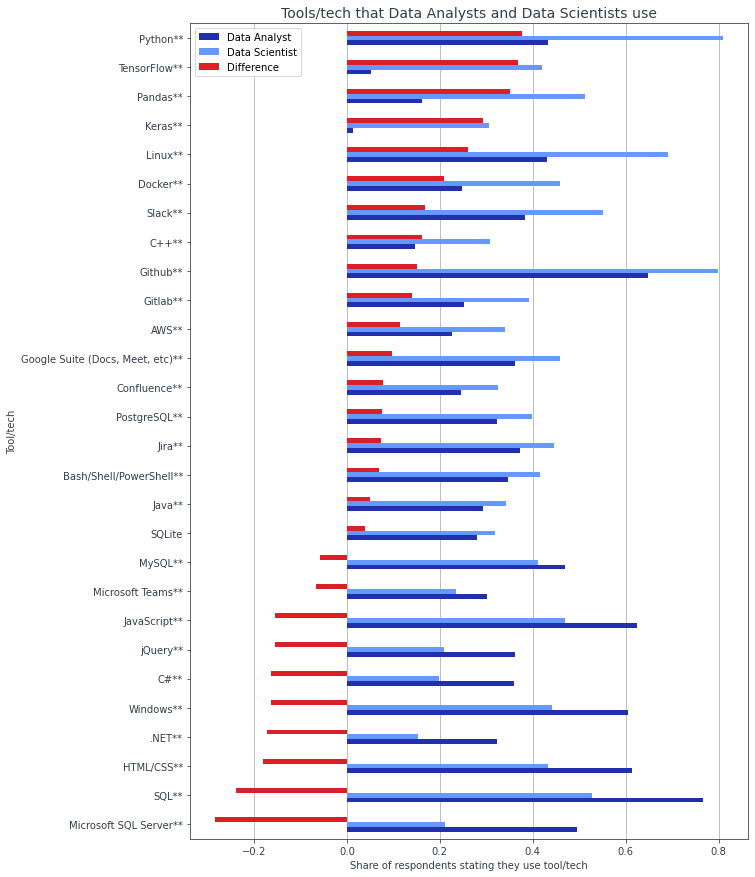

In [77]:
plotting(dfs_cooc3,
         'DA_only_share',
         'DS_only_share',
         'Tool/tech',
         'Share of respondents stating they use tool/tech',
         'Tools/tech that Data Analysts and Data Scientists use',
         'Data Analyst',
         'Data Scientist')

##### Analysis for 2-way split with partial overlap (DA, DS)

Data preparation

In [78]:
# Create co-occurence table
dfs_cooc4_da = grouping(dfs_tools,
                        all_tools,
                        'Data or business analyst',
                        True)
dfs_cooc4_ds = grouping(dfs_tools,
                        all_tools,
                        'Data scientist or machine learning specialist',
                        True)
dfs_cooc4 = merging_2col(dfs_cooc4_da, dfs_cooc4_ds)

# Add a difference column
dfs_cooc4 = diffcol_2col(dfs_cooc4)

# Remove tools with low endorsement
dfs_cooc4 = endorsement(0.3,
                        dfs_cooc4,
                        'Data or business analyst',
                        'Data scientist or machine learning specialist')

Chart

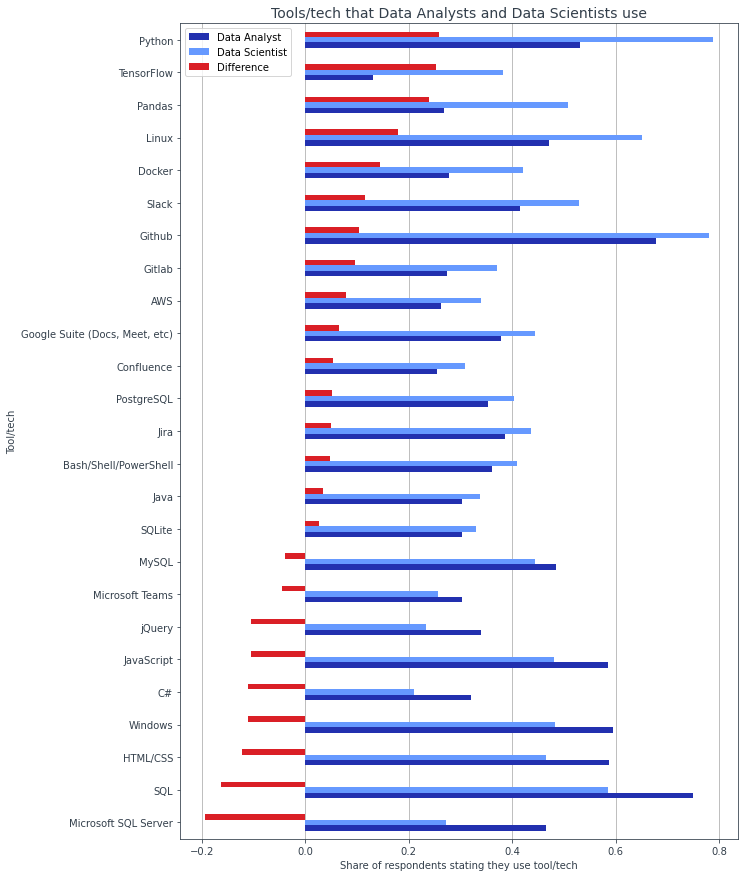

In [79]:
plotting(dfs_cooc4,
         'Data or business analyst',
         'Data scientist or machine learning specialist',
         'Tool/tech',
         'Share of respondents stating they use tool/tech',
         'Tools/tech that Data Analysts and Data Scientists use',
         'Data Analyst',
         'Data Scientist')

## Question 1.3: Do tools that Data Analysts and Data Scientists want to use next year differ?

In [80]:
# List all columns that refer to tech and tools variables FOR LEARNING
column_list_dny = ['MiscTechDesireNextYear',
                   'LanguageDesireNextYear',
                   'NEWCollabToolsDesireNextYear',
                   'DatabaseDesireNextYear',
                   'PlatformDesireNextYear',
                   'WebframeDesireNextYear']

In [81]:
# Create columns in df for all tools
dfs_tools_dny, issue_list_dny = dummies(dfs, column_list_dny)

In [82]:
# Create list with all tools
all_tools_dny = subset_creator(dfs_tools_dny, column_list_dny)

##### Analysis for 3-way split (DA only, DS only, DA and DS)

Create grouped co-occurence table

In [83]:
dfs_cooc5 = grouping_1col('Stackoverflow',
                          dfs_tools_dny,
                          'DevType_RoleDescription',
                          all_tools_dny,
                          n_dicts)

Remove variables with low endorsement

In [84]:
dfs_cooc5 = endorsement(0.3,
                        dfs_cooc5,
                        'DA_only_share',
                        'DS_only_share')

Sig test

In [85]:
dfs_result_tools_dny, dfs_result_tools_dny_ba, sig_dvar_s_dny_tools = t_testing(dfs_cooc5,
                                                                                list(dfs_cooc5.index),
                                                                                'DA_only_share',
                                                                                'DS_only_share',
                                                                                n_da_only,
                                                                                n_ds_only,
                                                                                [])

Add sig-stars to table pre-charting

In [86]:
dfs_cooc5 = sig_stars(dfs_cooc5, sig_dvar_s_dny_tools)

Chart

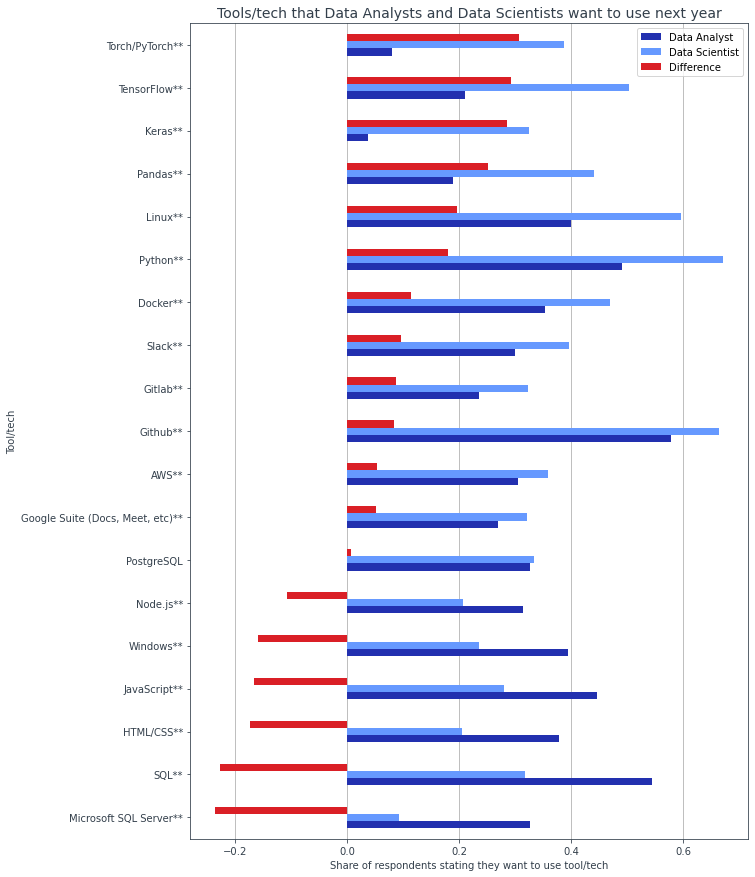

In [87]:
plotting(dfs_cooc5,
         'DA_only_share',
         'DS_only_share',
         'Tool/tech',
         'Share of respondents stating they want to use tool/tech',
         'Tools/tech that Data Analysts and Data Scientists want to use next year',
         'Data Analyst',
         'Data Scientist')

##### Analysis for 2-way split with partial overlap (DA, DS)

Data preparation

In [88]:
# Create co-occurence table
dfs_cooc6_da = grouping(dfs_tools_dny,
                        all_tools_dny,
                        'Data or business analyst',
                        True)
dfs_cooc6_ds = grouping(dfs_tools_dny,
                        all_tools_dny,
                        'Data scientist or machine learning specialist',
                        True)
dfs_cooc6 = merging_2col(dfs_cooc6_da, dfs_cooc6_ds)

# Add a difference column
dfs_cooc6 = diffcol_2col(dfs_cooc6)

# Remove tools with low endorsement
dfs_cooc6 = endorsement(0.3,
                        dfs_cooc6,
                        'Data or business analyst',
                        'Data scientist or machine learning specialist')

Chart

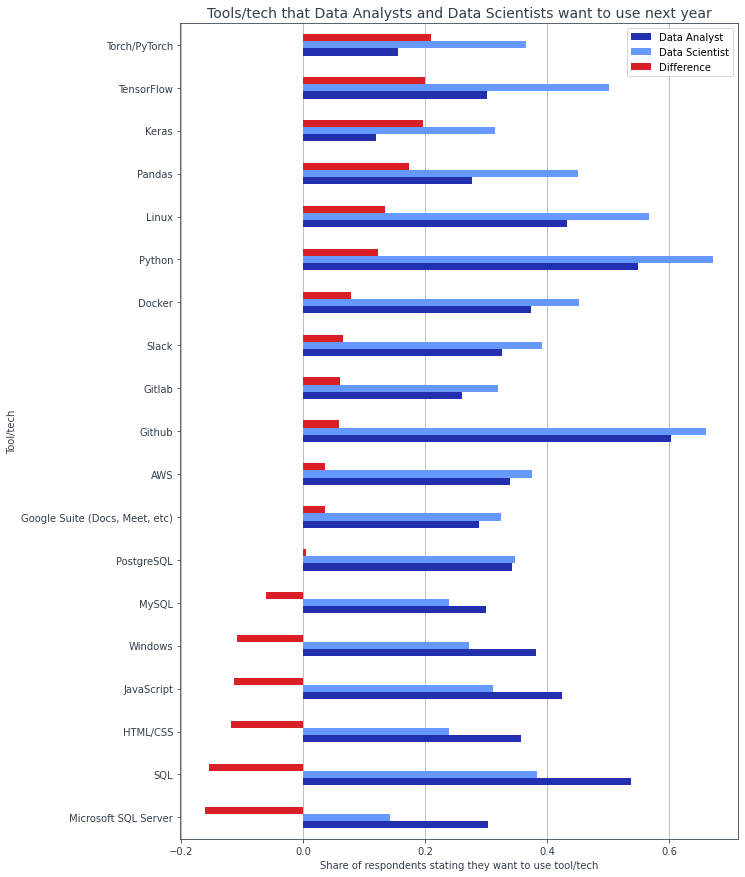

In [89]:
plotting(dfs_cooc6,
         'Data or business analyst',
         'Data scientist or machine learning specialist',
         'Tool/tech',
         'Share of respondents stating they want to use tool/tech',
         'Tools/tech that Data Analysts and Data Scientists want to use next year',
         'Data Analyst',
         'Data Scientist')

# Part 2 - The Kaggle Job Data

## Inspect data

In [90]:
dfk.head()

Unnamed: 0  index                          Job Title  \
0           0      0              Senior Data Scientist   
1           1      1  Data Scientist, Product Analytics   
2           3      3                       Data Analyst   
3           5      5                     Data Scientist   
4          10     10                     Data Scientist   

                Salary Estimate  \
0  $111K-$181K (Glassdoor est.)   
1  $111K-$181K (Glassdoor est.)   
2  $111K-$181K (Glassdoor est.)   
3  $111K-$181K (Glassdoor est.)   
4  $111K-$181K (Glassdoor est.)   

                                     Job Description  Rating  \
0  ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...     3.5   
1  At Noom, we use scientifically proven methods ...     4.5   
2  Sapphire Digital seeks a dynamic and driven mi...     3.4   
3  Job Brief\n\nThe ideal candidate will have pre...     2.9   
4  Company Description:\n\nQuartet is a pioneerin...     3.9   

            Company Name       Location      Headquarters  \
0            Hopper\n3.5   New York, NY  Montreal, Canada   
1           Noom US\n4.5   New York, NY      New York, NY   
2  Sapphire Digital\n3.4  Lyndhurst, NJ     Lyndhurst, NJ   
3     IFG Companies\n2.9   New York, NY      Hartford, CT   
4    Quartet Health\n3.9   New York, NY      New York, NY   

                     Size  Founded  Type of ownership  \
0   501 to 1000 employees     2007  Company - Private   
1  1001 to 5000 employees     2008  Company - Private   
2    201 to 500 employees     2019  Company - Private   
3    201 to 500 employees     1985  Company - Private   
4    201 to 500 employees     2014  Company - Private   

                                  Industry                  Sector  \
0                          Travel Agencies        Travel & Tourism   
1                Health, Beauty, & Fitness       Consumer Services   
2                                 Internet  Information Technology   
3                       Insurance Carriers               Insurance   
4  Enterprise Software & Network Solutions  Information Technology   

                    Revenue                    Competitors Easy Apply  \
0  Unknown / Non-Applicable                             -1         -1   
1  Unknown / Non-Applicable                             -1         -1   
2  Unknown / Non-Applicable           Zocdoc, Healthgrades         -1   
3  Unknown / Non-Applicable  Colony Specialty, Markel, RLI         -1   
4  Unknown / Non-Applicable                             -1       TRUE   

   Data Analyst  Business Intelligence Analyst  Business Analyst  \
0             0                              0                 0   
1             0                              0                 0   
2             1                              0                 0   
3             0                              0                 0   
4             0                              0                 0   

   Data Scientist  Machine Learning Specialist  DA  DS  Both titles  FILTER  \
0               1                            0   0   1            0       1   
1               1                            0   0   1            0       1   
2               0                            0   1   0            0       1   
3               1                            0   0   1            0       1   
4               1                            0   0   1            0       1   

   Python  
0       0  
1       1  
2       1  
3       1  
4       1

In [91]:
# Understand recency of dataset based on company foundation dates 
# >> contains companies that were founded recently
dfk['Founded'].value_counts().sort_index()

-1       443
 1625      2
 1740      7
 1784      1
 1799     15
        ... 
 2016     21
 2017     24
 2018     11
 2019      7
 2020      1
Name: Founded, Length: 137, dtype: int64

In [92]:
# Check for base size
dfk.shape

(1791, 27)

In [93]:
# Check data-types
dfk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1791 entries, 0 to 1790
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     1791 non-null   int64  
 1   index                          1791 non-null   int64  
 2   Job Title                      1791 non-null   object 
 3   Salary Estimate                1791 non-null   object 
 4   Job Description                1791 non-null   object 
 5   Rating                         1791 non-null   float64
 6   Company Name                   1791 non-null   object 
 7   Location                       1791 non-null   object 
 8   Headquarters                   1791 non-null   object 
 9   Size                           1791 non-null   object 
 10  Founded                        1791 non-null   int64  
 11  Type of ownership              1791 non-null   object 
 12  Industry                       1791 non-null   o

**How to handle missings**
* Missings are marked with -1, not nan or similar
* Missings are not an issue for this analysis, as the data will be filtered accordingly and recoded using regex.

## Create comprehensive list of tools

Sources: 
* Tools listed in Stackoverflow survey
* Top BI, statistical software & data visualisation tools as found online: (Note: There is a plethora of tools out there. After some research I came up with the list below which contains, to my knowledge, all currently highly popular tools plus some more I am myself unfamiliar with. In the analysis, any tools that have low incidence will be removed)
    * https://www.datapine.com/articles/best-bi-tools-software-review-list
     * Datapine
     * SAS
     * Clear Analytics
     * SAP
     * Domo
     * Metric Insights
     * Zoho Analytics
     * Microstrategy
     * Gooddata
     * Cognos Analytics (by IBM)
     * QlikView
     * Yellowfin
    * https://towardsdatascience.com/top-5-bi-tools-that-you-must-use-for-data-visualization-7ccc2a852bd3
     * Qlik Sense
     * Tableau
     * Power BI (by Microsoft)
     * SAP Hana
    * https://www.cio.com/article/3322749/top-business-intelligence-bi-tools.html
     * Board (remove as potentially confusing word)
     * Dundas BI
     * MicroStrategy
     * Oracly Analytics Cloud
     * Sisense
     * Tibco
    * https://www.forbes.com/sites/bernardmarr/2020/05/22/the-9-best-analytics-tools-for-data-visualization-available-today/?sh=36ebb06a4743
     * Infogram
     * Google Charts
     * Paraview
     * Looker
    * https://uk.pcmag.com/cloud-services/83744/the-best-data-visualization-tools-for-2020
     * Google Analytics
    * https://mopinion.com/business-intelligence-bi-tools-overview/
     * Oracle BI
    * https://www.trustradius.com/business-intelligence-bi
     * SAP Analytics Cloud
    * Selection of https://www.capterra.com/statistical-analysis-software/
     * SPSS
     * Stata
     * Minitab
     * Matlab
     * Alteryx
     * Google DataStudio
* Excel
* Adding other names of tools in list, e.g. abbreviations of names (e.g. GCP = Google Cloud Platform)

In [94]:
online_research_list = ['Datapine',
                        'SAS',
                        'Clear Analytics',
                        'SAP',
                        'Domo',
                        'Metric Insights',
                        'Zoho Analytics',
                        'Microstrategy',
                        'GoodData',
                        'Cognos Analytics',
                        'QlikView',
                        'Yellowfin',
                        'Qlik Sense',
                        'Tableau',
                        'Power BI',
                        'SAP Hana',
                        'Dundas BI',
                        'MicroStrategy',
                        'Oracle Analytics Cloud',
                        'Sisense',
                        'Tibco',
                        'Infrogram',
                        'Google Charts',
                        'Paraview',
                        'Looker',
                        'Google Analytics',
                        'Oracle BI',
                        'SAP Analytics Cloud',
                        'SPSS',
                        'Stata',
                        'Minitab',
                        'Matlab',
                        'Alteryx',
                        'Data Studio']

In [95]:
# Retrieving all DevTypes from the Stackoverflow data
all_tools = subset_creator(dfs_tools, column_list)

In [96]:
# Compiling a comprehensive list without duplicates, sorted
full_list = all_tools + online_research_list + ['Excel', 'MS Office'] + ['Workplace', 'Azure', 'Bash', 'Shell', 'PowerShell', 'IBM Cloud',
                                                                         'IBM Watson', 'Google Suite', 'Slack', 'SQL Server', 'GCP', 'Torch', 'PyTorch', 'Amazon Web Services', 'Visual Basic', 'PowerBI']
full_list = list(set(full_list))
full_list = sorted(full_list, key=lambda x: x.upper())

In [97]:
# Creating dictionary with all pairs (e.g. AWS = Amazon Web Services)
pair_dict = {'AWS': 'Amazon Web Services',
             'Azure': 'Microsoft Azure',
             'Microsoft SQL Server': 'SQL Server',
             'Workplace': 'Facebook Workplace',
             'Bash': 'Shell',
             'Bash': 'PowerShell',
             'Google Cloud Platform': 'GCP',
             'VBA': 'Visual Basic',
             'Power BI': 'PowerBI'}

In [98]:
# Dropping items that were completely replaced/split up (e.g. IBM Cloud or Watson >> IBM Cloud; IBM Watson)
removal_list = ['Slack Apps and Integrations',
                'IBM Cloud or Watson',
                'Bash/Shell/PowerShell',
                'Google Suite (Docs, Meet, etc)',
                'Torch/Pytorch']
full_list = [i for i in full_list if i not in removal_list]

## Filter

**Sensible Filters**

**Job Title**: Only job titles that contain the key descriptions: Data Analyst, Business Intelligence Analyst, Business Analyst, Data Scientist, Machine Learning Specialist

In [99]:
# Select jobs that contain "Data Scientist", "Data Analyst" or similar
dfk_f = dfk.loc[dfk['Job Title'].str.contains(
    r'Data Analyst|Business Intelligence Analyst|Business Analyst|Data Scientist|Machine Learning Specialist')]

In [100]:
# Check new base size >> reduced from 3909 to 1794
dfk_f.shape

(1791, 27)

## Mark job postings as Data Analyst or Data Scientist postings

In [101]:
# Add binary identifiers for Data Analyst and Data Scientist
dfk_f['Data or business Analyst'] = 0
dfk_f.loc[dfk_f['Job Title'].str.contains(
    r'Data Analyst|Business Intelligence Analyst|Business Analyst'),
    'Data or business Analyst'] = 1

dfk_f['Data scientist or machine learning specialist'] = 0
dfk_f.loc[dfk_f['Job Title'].str.contains(
    r'Data Scientist|Machine Learning Specialist'),
    'Data scientist or machine learning specialist'] = 1

In [102]:
# Check if there is overlap
dfk_f['Both job titles'] = (dfk_f['Data or business Analyst']
                            + dfk_f['Data scientist or machine learning specialist'])
dfk_f['Both job titles'].value_counts()

1    1791
Name: Both job titles, dtype: int64

In [103]:
# Remove ambiguous job titles (losing 3 rows >> minimal loss)
dfk_f = dfk_f.loc[dfk_f['Both job titles'] == 1]

In [104]:
# Create column that identifies DA and DS jobs
dfk_f['Job Title Reduced'] = 'no information'
dfk_f.loc[dfk_f['Data or business Analyst'] == 1,
          'Job Title Reduced'] = 'DA'
dfk_f.loc[dfk_f['Data scientist or machine learning specialist'] == 1,
          'Job Title Reduced'] = 'DS'

In [105]:
# Store base sizes for further analysis
n_da_k = dfk_f.loc[dfk_f['Job Title Reduced'] == 'DA']['index'].count()
n_ds_k = dfk_f.loc[dfk_f['Job Title Reduced'] == 'DS']['index'].count()

In [106]:
print("Base size DA: ", n_da_k)
print("Base size DS: ", n_ds_k)

Base size DA:  814
Base size DS:  977


## Create columns for tech/tools (0/1 coded)

In [107]:
# Create one column per tool
dfk_f[full_list] = np.nan

In [108]:
# Add 1 for tool if mentioned in job description.
'''
Need to add r1 and r2 because of e.g. C and R, 
which would otherwise be counted when the letter appears.
'''
for i in full_list:
    r1 = r"[\s.,;:/(*]"
    r2 = r"[\s.,;:/)*^]"
    regex_string = re.compile(r1 + re.escape(i) + r2, re.IGNORECASE)
    dfk_f.loc[dfk_f['Job Description'].str.contains(regex_string), i] = 1

In [109]:
dfk_f = dfk_f.fillna(0)

In [110]:
# Merge columns from pair_list and drop superfluous columns
for key in pair_dict:
    dfk_f[key] = dfk_f[key] + dfk_f[pair_dict[key]]
    dfk_f = dfk_f.drop([pair_dict[key]], axis=1)
    dfk_f.loc[dfk_f[key] > 1, key] = 1

## Question 2.1: Do tool/tech requirements in job ads differ for Data Analysts and Data Scientists?

Create grouped co-occurence table

In [111]:
# Create dictionary for base sizes
n_dictk = {'DA': n_da_k, 'DS': n_ds_k}

In [112]:
# Adjust full list
for key in pair_dict:
    full_list.remove(pair_dict[key])

In [113]:
dfk_cooc1 = grouping_1col('Kaggle',
                          dfk_f,
                          'Job Title Reduced',
                          full_list,
                          n_dictk)

Remove variables with low endorsement

In [114]:
dfk_cooc1 = endorsement(0.1,
                        dfk_cooc1,
                        'DA_share',
                        'DS_share')

Sig-test

In [115]:
dfk_result_tools, dfk_result_tools_ba, sig_dvar_k_tools = t_testing(dfk_cooc1,
                                                                    list(dfk_cooc1.index),
                                                                    'DA_share',
                                                                    'DS_share',
                                                                    n_da_k,
                                                                    n_ds_k,
                                                                    [])

Add sig stars to table pre-charting

In [116]:
dfk_cooc1 = sig_stars(dfk_cooc1, sig_dvar_k_tools)

Chart

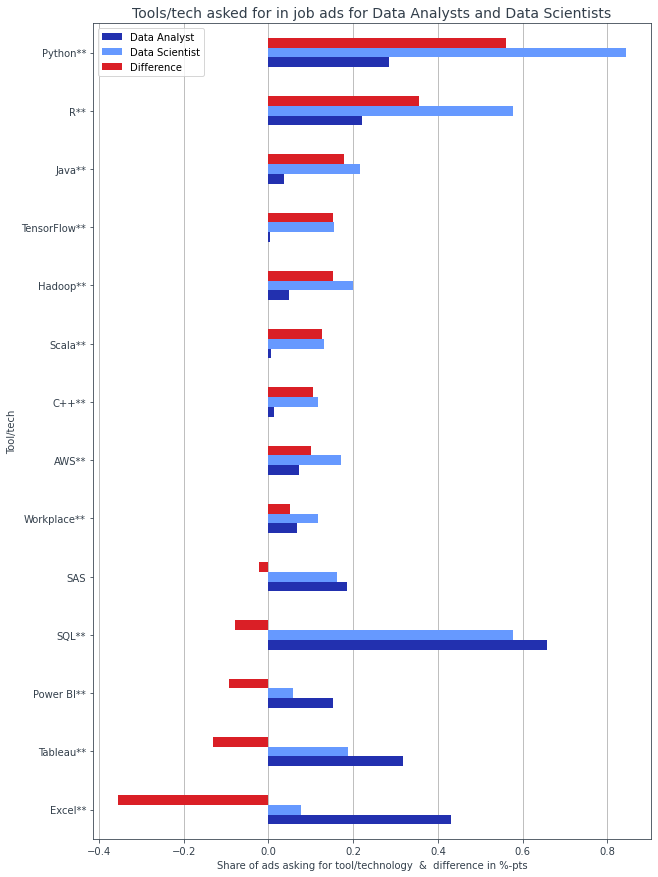

In [117]:
plotting(dfk_cooc1,
         'DA_share',
         'DS_share',
         'Tool/tech',
         'Share of ads asking for tool/technology  &  difference in %-pts',
         'Tools/tech asked for in job ads for Data Analysts and Data Scientists',
         'Data Analyst',
         'Data Scientist')